# PROJET 8 : Déployez un modèle dans le cloud
*Mathieu GENTHON (octobre-novembre 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies](#2)<a class="anchor" id="sommaire"></a>
### 3 - [Exploration data set](#3)<a class="anchor" id="sommaire"></a>
### 4 - [Processing](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Résultats](#5)<a class="anchor" id="sommaire"></a>

### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.
De plus, le développement de l’application mobile permettra de construire une première version de l'architecture Big Data nécessaire.
Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.


Il n’est pas nécessaire d’entraîner un modèle pour le moment.

L’important est de mettre en place les premières briques de traitement qui serviront lorsqu’il faudra passer à l’échelle en termes de volume de données !

Vous devrez tenir compte dans vos développements du fait que le volume de données va augmenter très rapidement après la livraison de ce projet. Vous développerez donc des scripts en Pyspark et utiliserez par exemple le cloud AWS pour profiter d’une architecture Big Data (EC2, S3, IAM).
La mise en œuvre d’une architecture Big Data sous (par exemple) AWS peut nécessiter une configuration serveur plus puissante que celle proposée gratuitement (EC2 = t2.micro, 1 Go RAM, 8 Go disque serveur).

### 2 - [Importation des librairies](#2)<a class="anchor" id="2"></a>

In [3]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import s3fs
import fsspec

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.ml.image import ImageSchema
import pyspark

In [4]:
pyspark.__version__

'3.0.1'

#### Important : Des erreurs apparaissaient jusqu'au remplacement de Java 1.11 par Java 1.8. Une manipulation dans apache arrow est possible dans Java 1.11 pour régler le problème.

In [5]:
'''
Il n'est pas nécessaire de lancer ces commandes quand on a lancé le notebook jupyter avec la commande pyspark car la
session spark est automatiquement lancé.
De la même manière, il suffit de choisir un noyau Pyspark quand on lance depuis un notebook AWS EMR.
spark = (SparkSession
            .builder
            .master('local[*]') \
            .appName("Projet8test")
            .getOrCreate()
)
sc = spark.sparkContext
'''

'\nIl n\'est pas nécessaire de lancer ces commandes quand on a lancé le notebook jupyter avec la commande pyspark car la\nsession spark est automatiquement lancé.\nDe la même manière, il suffit de choisir un noyau Pyspark quand on lance depuis un notebook AWS EMR.\nspark = (SparkSession\n            .builder\n            .master(\'local[*]\')             .appName("Projet8test")\n            .getOrCreate()\n)\nsc = spark.sparkContext\n'

### 3 - [Exploration data set](#3)<a class="anchor" id="3"></a>

In [50]:
img_dir = "/home/mathieukubuntu/Documents/oc-p8/fruits-360/Test2/**" # 
image_df = spark.read.format("image").load(img_dir)
# Getting the label by splitting the path of the image and getting its last directory
image_df = (image_df.withColumn('label',element_at(split(image_df['image.origin'],"/"),-2)))
image_df.collect()
image_df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- label: string (nullable = true)



In [51]:
print(image_df)
image_df.select("image.origin", "image.width", "image.height",
                 "image.nChannels", "image.mode","label").show(5,True)

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>, label: string]
+--------------------+-----+------+---------+----+-------------+
|              origin|width|height|nChannels|mode|        label|
+--------------------+-----+------+---------+----+-------------+
|file:/home/mathie...|  100|   100|        3|  16|Cucumber_Ripe|
|file:/home/mathie...|  100|   100|        3|  16|Cucumber_Ripe|
|file:/home/mathie...|  100|   100|        3|  16|Cucumber_Ripe|
|file:/home/mathie...|  100|   100|        3|  16|Cucumber_Ripe|
|file:/home/mathie...|  100|   100|        3|  16|Cucumber_Ripe|
+--------------------+-----+------+---------+----+-------------+
only showing top 5 rows



image type: <class 'pyspark.sql.types.Row'>, number of fields: 6
image path: file:/home/mathieukubuntu/Documents/oc-p8/fruits-360/Test2/Cucumber_Ripe/r_164_100.jpg
height: 100, width: 100, OpenCV type: 16
number of images in a df: 6009


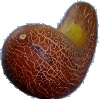

In [62]:
import cv2
data_fruits_ex = image_df.take(3)    # take first three rows of the dataframe
im_fruits = data_fruits_ex[2][0]          

print("image type: {}, number of fields: {}".format(type(im_fruits), len(im_fruits)))
print("image path: {}".format(im_fruits.origin))
print("height: {}, width: {}, OpenCV type: {}".format(im_fruits.height, im_fruits.width, im_fruits.mode))



arr_fruits = ImageSchema.toNDArray(im_fruits)     # convert to numpy array
print("number of images in a df:", image_df.count()) # number of image in df
arr_fruits = cv2.cvtColor(arr_fruits, cv2.COLOR_BGR2RGB) # convert format BGR to RGB
Image.fromarray(arr_fruits)   # display the image inside notebook

### 4 - [Processing](#4)<a class="anchor" id="4"></a>

In [27]:
Work_local = True

In [7]:
if Work_local == True:
    dir_test = "/home/mathieukubuntu/Documents/oc-p8/fruits-360/Test1/" # Local folder
else:
    dir_test = "s3://oc-p8/dat/" # Folder on S3

In [8]:
# Create spark data frame binaryfile. Load the files from the subdirectories by ignoring partition
# load jpg files by preserving the partition
images_bin = spark.read.format("binaryFile")\
    .option("recursiveFileLookup", "true")\
    .option("pathGlobFilter", "*.jpg")\
    .load(dir_test)

In [9]:
images_bin = images_bin.withColumn('label', element_at(split(images_bin['path'], "/"),-2))
print(images_bin.printSchema())
print(images_bin.select("path", "label").show(3,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------------------------+-----------+
|path                                                                                |label      |
+------------------------------------------------------------------------------------+-----------+
|file:/home/mathieukubuntu/Documents/oc-p8/fruits-360/Test1/Cauliflower/r_183_100.jpg|Cauliflower|
|file:/home/mathieukubuntu/Documents/oc-p8/fruits-360/Test1/Cauliflower/r_173_100.jpg|Cauliflower|
|file:/home/mathieukubuntu/Documents/oc-p8/fruits-360/Test1/Cauliflower/r_181_100.jpg|Cauliflower|
+------------------------------------------------------------------------------------+-----------+
only showing top 3 rows

None


In [10]:
# Use of VGG 16 transfer learning (imagenet) to extract features from our images.
model = VGG16(include_top=False, input_shape=(100,100,3))
brodcast_weights = sc.broadcast(model.get_weights())
model.summary()  # verify that the top layer is removed

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________

In [11]:
def model_fct():
    # returns a VGG 16 model with top layer removed and brodacasted weight
    model = VGG16(weights=None, include_top=False, input_shape=(100,100,3))
    model.set_weights(brodcast_weights.value)
    return model

In [12]:
def preprocess(content):
    # preprocesses raw image bytes for VGG 16 prediction.
    img = Image.open(io.BytesIO(content)) # No need to resize as last layer is removed .resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    # Featurize a pd.Series of raw images using the input model. Return: a pd.Series of image features
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # flatten features tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [13]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    # pandas user defined function to make operation on dataframe with pyspark.sql.
    model = model_fct()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/mathieukubuntu/spark/spark-3.0.1-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [14]:
# Repartion over 16 or 24 partition ( numb of part = 3 * cores number, use of pandas UDF)
features_df = images_bin.repartition(16).select(col("path"), col("label"),
                                        featurize_udf("content").alias("features"))

In [15]:
# write results on parquet file.
if Work_local == True:
    features_df.write.mode("overwrite").parquet("/home/mathieukubuntu/Documents/oc-p8/local_result")
else:
    features_df.write.mode("overwrite").parquet("s3://oc-p8/result/image_feat_all")

### 5 - [Résultats](#5)<a class="anchor" id="5"></a>

In [23]:
if Work_local == True:
    df = pd.read_parquet('/home/mathieukubuntu/Documents/oc-p8/local_result', engine='pyarrow')
    print("number of features extracted :",len(df['features'][0].tolist()))
else:
    df_parquet = spark.read.format('parquet').load('s3a://oc-p8/result/image_feat_all')
    df_parquet.show(10)
    df_parquet.count()

number of features extracted : 4608


In [28]:
df.head(100)

,path,label,features
0,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Cauliflower,"[9.192255, 0.0, 81.21479, 0.0, 0.0, 0.0, 0.0, ..."
1,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Cauliflower,"[1.4845908, 0.0, 61.514027, 0.0, 0.0, 0.0, 0.0..."
2,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Cauliflower,"[7.5642242, 0.0, 60.33179, 0.0, 0.0, 0.0, 0.0,..."
3,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Cauliflower,"[12.300638, 0.0, 66.90629, 0.0, 0.0, 0.0, 0.0,..."
4,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Cauliflower,"[0.0, 0.0, 82.599754, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
95,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Beetroot,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
96,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Apple_Crimson_Snow,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
97,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Apple_Red_Yellow_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
98,file:/home/mathieukubuntu/Documents/oc-p8/frui...,Corn,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
df['features'][10].tolist()

[21.69896125793457,
 0.0,
 180.87619018554688,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 16.812772750854492,
 0.0,
 0.0,
 31.36916160583496,
 0.0,
 0.0,
 0.0,
 3.1426353454589844,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 69.42509460449219,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 36.059814453125,
 24.16006851196289,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 24.966108322143555,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6138249635696411,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 9.444050788879395,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 96.17259979248047,
 38.520389556